In [1]:
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib.dates import MonthLocator, YearLocator
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
pd.set_option('display.mpl_style', 'default')

def print_missing_stats(train, test, store_info):
    for data_name, data in {'TRAIN': train, 'TEST': test, 'STORE': store_info}.items():
        print(data_name, ' (overall = %d)' % len(data))
        for attribute in data.columns:
            mask = data[attribute].isnull()
            k = len(data[attribute][mask])
            print('%5d (%2d%%)' % (k, 100*k/len(data)), 'missing values in ', attribute) 
        print()

def load_data(filename_train, filename_test, filename_store, print_missing=False):

    train = pd.read_csv(filename_train, header=0, low_memory=False)
    test = pd.read_csv(filename_test, header=0, low_memory=False)
    store_info = pd.read_csv(filename_store, header=0, low_memory=False)

    train.Date = pd.to_datetime(train.Date)
    test.Date = pd.to_datetime(test.Date)
    
    if print_missing:
        print('BEFORE:')
        print_missing_stats(train, test, store_info)
    
    test.Open = test.Open.fillna(1)

    store_info.CompetitionDistance = store_info.CompetitionDistance.fillna(0)
    store_info.CompetitionOpenSinceMonth = store_info.CompetitionOpenSinceMonth.fillna(0).astype(int)
    store_info.CompetitionOpenSinceYear = store_info.CompetitionOpenSinceYear.fillna(0).astype(int)
    store_info.Promo2SinceWeek = store_info.Promo2SinceWeek.fillna(0).astype(int)
    store_info.Promo2SinceYear = store_info.Promo2SinceYear.fillna(0).astype(int)

    promo_intervals = [np.NaN] + list(store_info.PromoInterval.value_counts().index)
    store_info.PromoInterval = store_info.PromoInterval.map(lambda x: promo_intervals.index(x))
    
    if print_missing:
        print('AFTER:')
        print_missing_stats(train, test, store_info)
    return train, test, store_info

In [2]:
def plot_all_store_sales(train):
    fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

    open_df = train[train.Open == 1]
    for day_of_week in range(1, 8):
        custom_df = open_df[open_df.DayOfWeek == day_of_week] 
        gp_store = custom_df.groupby('Store')

        for store, group in gp_store:
            axes[day_of_week - 1].plot(group['Date'], group['Sales'], 'v--')

        gp_date = custom_df.groupby('Date')

        ts_mean = gp_date['Sales'].mean()
        ts_median = gp_date['Sales'].median()
        ts_mean.plot(style='r-', linewidth=5, ax=axes[day_of_week - 1], label='mean')
        ts_median.plot(style='b-', linewidth=5, ax=axes[day_of_week - 1], label='median')


        axes[day_of_week - 1].set_title('Day ' + str(day_of_week) + '. number of stores = ' + str(len(gp_store)))
        axes[day_of_week - 1].legend()
        axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
        axes[day_of_week - 1].grid(True)
    pl.savefig('all_stores_and_median.png', format='png')

In [3]:
def construct_label_name(school_holiday, state_holiday, promo_flag, n_stores):
    string_school = 'NO SchoolHoliday. '
    string_state = 'NO StateHoliday. '
    string_promo = 'NO Promo. '
    if school_holiday == 1:
        string_school = string_school[3:]
    if promo_flag:
        string_promo = string_promo[3:]
    if state_holiday != '0':
        string_state = {'a': 'PublicHoliday. ',
                        'b': 'EasterHoliday. ',
                        'c':'Christmas. '}[state_holiday]
    string_stores = '(' + str(n_stores) + ' stores)'
    return string_school + string_state + string_promo + string_stores

def plot_mean_decomposition(train):
    fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(20,100))

    open_df = train[train.Open == 1]
    for day_of_week in range(1, 8):
        day_df = open_df[open_df.DayOfWeek == day_of_week]
        for school_holiday in [0, 1]:
            school_df = day_df[day_df.SchoolHoliday == school_holiday]
            for state_holiday in ['0', 'a', 'b', 'c']:
                state_df = school_df[school_df.StateHoliday == state_holiday]
                for promo_flag in [0, 1]:
                    custom_df = state_df[state_df.Promo == promo_flag]
                    if not custom_df.empty:
                        gp_date = custom_df.groupby('Date')
                        gp_store = custom_df.groupby('Store')

                        ts_mean = gp_date.Sales.mean()
                        axes[day_of_week - 1].plot(ts_mean.index, ts_mean, 'v--', 
                                                   label=construct_label_name(school_holiday, state_holiday, 
                                                                              promo_flag, len(gp_store)))

        custom_df = day_df
        gp_date = custom_df.groupby('Date')
        gp_store = custom_df.groupby('Store')
        ts_mean = gp_date.Sales.mean()
        ts_mean.plot(style='r-', linewidth=1.5, ax=axes[day_of_week - 1],
                     label='mean (' + str(len(gp_store)) + ' stores)')
        axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
        axes[day_of_week - 1].legend()
        axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
        axes[day_of_week - 1].grid(True)
    
    
    pl.savefig('median_decomposition.png', format='png')

In [4]:
def get_dates_CV(k):
    if k >= 20:
        k = 19
        print('maximum number of cross-validation folds is 19')
    date_range = pd.date_range('2013-01-01', '2015-07-31')
    for i in range(k):
        temp_date_range = date_range.shift(-i*48)[48*i:]
        train_date_range = temp_date_range[:-48]
        test_date_range = temp_date_range[-48:] 
        yield train_date_range, test_date_range

In [5]:
def merge_with_store(data, store_info):    
    store_features = ['Store', 'StoreType', 'Assortment','CompetitionDistance', 
                      'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                      'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
    data = pd.merge(data, store_info[store_features], on='Store', how='left')
    return data

def get_dummies_values(series, prefix, values):
    new_series = pd.get_dummies(series, prefix=prefix)
    for value in values:
        column_name = prefix + '_' + str(value)
        if column_name not in new_series.columns:
            new_series = new_series.join(pd.DataFrame(np.zeros(len(new_series), dtype=int), index=new_series.index,
                                                   columns=[column_name]))
    columns = sorted(new_series.columns)
    return new_series[columns]

In [6]:
def construct_some_features(data):
    data['Day'] = data.Date.map(lambda d: d.day).astype(int)
    data['Month'] = data.Date.map(lambda d: d.month).astype(int)
    data['Week'] = data.Date.map(lambda d: d.week).astype(int)
    data['DayOfYear'] = data.Date.map(lambda d: d.dayofyear).astype(int)
    data['Year'] = data.Date.map(lambda d: d.year)
   
    data['DiffToday'] = ((pd.datetime(2015, 9, 18) - data.Date)
                                     / np.timedelta64(1, 'D')).astype(int)
    data['DiffNewYear'] = data.Date.map(lambda d: (min(d - pd.datetime(d.year, 1, 1),
                                  pd.datetime(d.year + 1, 12, 31) - d) / np.timedelta64(1, 'D')).astype(int))
    data['DiffFoolDay'] = data.Date.map(lambda d: ((d - pd.datetime(d.year, 4, 1))
                                                                           / np.timedelta64(1, 'D')).astype(int))

    data = data.join(get_dummies_values(data.StateHoliday, prefix='StateHoliday', values=['0', 'a', 'b', 'c']))
    data = data.join(get_dummies_values(data.Month, prefix='Month', values=np.arange(1, 13)))
    data = data.join(get_dummies_values(data.StoreType, prefix='StoreType', values=['a', 'b', 'c', 'd']))
    data = data.join(get_dummies_values(data.Assortment, prefix='Assortment', values=['a', 'b', 'c']))
    data = data.join(get_dummies_values(data.DayOfWeek, prefix='DayOfWeek', values=np.arange(1, 8)))
    data = data.join(get_dummies_values(data.CompetitionOpenSinceMonth, prefix='CompetitionOpenSinceMonth',
                                        values=np.arange(1, 13)))
    data = data.join(get_dummies_values(data.Year, prefix='Year', values=[2013, 2014, 2015]))
    
    del data['StateHoliday'], data['Month'],
    del data['StoreType'], data['Assortment'], data['DayOfWeek'],
    del data['CompetitionOpenSinceMonth'], data['Year']
    return data

In [7]:
def construct_data(data, store_info, train_features):
    data = merge_with_store(data[train_features], store_info)
    data = construct_some_features(data)
    return data

In [8]:
def main_feature_construction(data):
    train_data, test_data, store_info = data
    train_data = train_data[train_data.Open == 1]
    
    train_features = ['Store', 'DayOfWeek', 'Date', 'Promo', 'SchoolHoliday', 'StateHoliday']
    
    train_data = construct_data(train_data, store_info, train_features + ['Sales'])
    columns = [x for x in train_data.columns if x != 'Sales']
    train_data = train_data[columns + ['Sales']]
    test_data = construct_data(test_data, store_info, train_features)
    
    assert all([str(x) == str(y) for x, y in zip(list(train_data.columns), list(test_data.columns) + ['Sales'])])
    
    return train_data, test_data

In [9]:
def get_data_CV(train_data, number_of_folds=1):
    for i, date_ranges in enumerate(get_dates_CV(number_of_folds)):
        date_range_train, date_range_test = date_ranges
        print('Fold #%d' % (i+1))
        print('     Train -> ', [str(date_ranges[0][0]), str(date_ranges[0][-1])])
        print('Validation -> ', [str(date_ranges[1][0]), str(date_ranges[1][-1])])
        
        train_fold = train_data[train_data.Date.isin(date_range_train)]
        test_fold = train_data[train_data.Date.isin(date_range_test)]
        train_fold_labels = np.array(train_fold.Sales)
        test_fold_labels = np.array(test_fold.Sales)
        del train_fold['Date'], test_fold['Date'], train_fold['Sales'], test_fold['Sales']
        yield np.array(train_fold), train_fold_labels, np.array(test_fold), test_fold_labels, train_fold.columns

def get_all_data(train_data, test_data):
    print('Train -> all dates')
    print(' Test -> need to predict')
    train_array_labels = np.array(train_data.Sales)
    train_array = train_data[[x for x in train_data.columns if x not in ['Sales', 'Date']]] 
    test_array = test_data[[x for x in test_data.columns if x != 'Date']]
    return np.array(train_array), train_array_labels, np.array(test_array), train_array.columns

### Predicting

In [10]:
def visualize_feature_importances(clf, features):
    pl.figure(figsize=(20,10))
    if hasattr(clf, 'coef_'):
        coefs = clf.coef_
        sorted_indices = np.argsort(coefs)[::-1]
        for i, k in enumerate(sorted_indices):
            print('%2d (feature %2d):' % (i, k), features[k], 'coef = %.8f' % coefs[k])
        pl.title('Coeffs of linear model')
        pl.bar(range(len(features)), coefs[sorted_indices], color='r')
        pl.xticks(range(len(features)), sorted_indices)
        pl.xlim([-1, len(features) + 1])
        
    elif hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        sorted_indices = np.argsort(importances)[::-1]
        for i, k in enumerate(sorted_indices):
            print('%2d (feature %2d):' % (i, k), features[k], 'Importance = %.5f' % importances[k])
        print([features[k] for k in sorted_indices])
        pl.title('Feature Importance')
        pl.bar(range(len(features)), importances[sorted_indices], color='r',
               yerr=std[sorted_indices], align='center')
        pl.xticks(range(len(features)), sorted_indices)
        pl.xlim([-1, len(features) + 1])
        pl.savefig('feature_importance.png', format='png')

def compute_RMSPE(test_labels, predicted_labels):
    mask = test_labels.nonzero()
    y = test_labels[mask]
    y_hat = predicted_labels[mask]
    return np.sqrt(np.mean(((y - y_hat)/y)**2))

def visualize_RMSPE(test_labels, predicted_labels, step = 0.05):
    for i in np.arange(0, 1, step):
        pl.figure(figsize=(20,7))
        pl.plot(test_labels[i*len(test_labels):(i+step)*len(test_labels)],
                'b.', label='real')
        pl.plot(predicted_labels[i*len(predicted_labels):(i+step)*len(predicted_labels)],
                'r.', label='predicted')
        pl.legend()

In [11]:
def fit_predict_model(train_array, train_array_labels, test_array, feature_names,
                      params=None, print_importances=True):
    
    if params:
        clf = RandomForestRegressor(n_jobs=-1, **params)
    else:
        clf = RandomForestRegressor(n_estimators=30, n_jobs=-1, min_samples_leaf=2,
                                    max_features=0.464285714286)
    
#     clf = Ridge(normalize=True, alpha=alpha)
    
    clf.fit(train_array, np.log(train_array_labels + 1.))
    if print_importances:
        visualize_feature_importances(clf, feature_names)
    
    test_predicted_labels = np.exp(clf.predict(test_array)) - 1
        
    return test_predicted_labels

### script begins

In [12]:
data = load_data('train.csv', 'test.csv', 'store.csv')

In [13]:
# plot_all_store_sales(data[0])

In [14]:
# plot_mean_decomposition(data[0])

#Main

In [26]:
train_data, test_data = main_feature_construction(data)
test = data[1][['Id', 'Open']]
print('train_data and test_data have been constructed')
del data
print('Memory usage of dataframe train_data is %3.2f Mb' % (train_data.memory_usage(index=True).sum()/(1024*1024)))
print('Memory usage of dataframe test_data is %3.2f Mb' % (test_data.memory_usage(index=True).sum()/(1024*1024)))

NameError: name 'data' is not defined

######58 features -> 0.12946233 on 3Fold CV

Train -> all dates
 Test -> need to predict
 0 (feature  3): CompetitionDistance Importance = 0.18250
 1 (feature  1): Promo Importance = 0.15185
 2 (feature  0): Store Importance = 0.13409
 3 (feature  4): CompetitionOpenSinceYear Importance = 0.06293
 4 (feature  6): Promo2SinceYear Importance = 0.03528
 5 (feature  5): Promo2SinceWeek Importance = 0.03259
 6 (feature 42): DayOfWeek_6 Importance = 0.02769
 7 (feature  8): Day Importance = 0.02470
 8 (feature 37): DayOfWeek_1 Importance = 0.02320
 9 (feature 11): DiffToday Importance = 0.02278
10 (feature  7): PromoInterval Importance = 0.01982
11 (feature 30): StoreType_a Importance = 0.01811
12 (feature 10): DayOfYear Importance = 0.01746
13 (feature 31): StoreType_b Importance = 0.01666
14 (feature 12): DiffNewYear Importance = 0.01664
15 (feature 13): DiffFoolDay Importance = 0.01583
16 (feature 34): Assortment_a Importance = 0.01516
17 (feature 33): StoreType_d Importance = 0.01139
18 (feature 50): CompetitionOpenSinceMonth_3 Imp

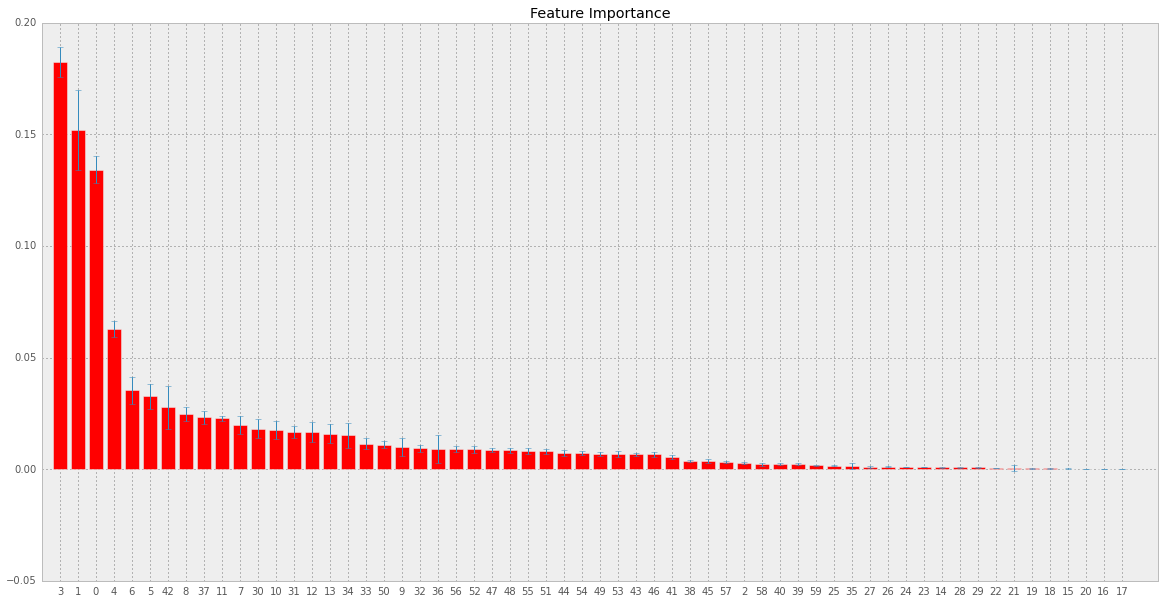

In [28]:
validation = True
feature_selection = None
if validation:
    number_of_folds = 1
    print_importances = False
    
    alphas, scores = [], []
    min_alpha, min_score = 1., 10**5
    grid_space = [1]
    
    for alpha in grid_space:
        rmspe_cv = 0. 
        
        for i, data_fold in enumerate(get_data_CV(train_data, number_of_folds)):
            train_fold, train_fold_labels, test_fold, test_fold_labels, feature_names = data_fold
            
            if i == number_of_folds - 1 and len(grid_space) <= 1:
                print('number of features =', len(feature_names))
                print_importances = True
            
            test_predicted_labels = fit_predict_model(train_fold, train_fold_labels, test_fold, 
                                                      feature_names=feature_names, 
                                                      print_importances=print_importances)
            rmspe_score = compute_RMSPE(test_fold_labels, test_predicted_labels)
            print('some rmspe_score = %1.8f' % rmspe_score)
            rmspe_cv += rmspe_score
        
        del train_fold, train_fold_labels, test_fold, test_fold_labels, data_fold
        
        rmspe_cv /= number_of_folds
        
        if len(grid_space) > 1:
            print('trying alpha =', alpha)
        print('Cross-validated RMSPE = %1.8f on %d folds' % (rmspe_cv, number_of_folds), end='\n\n')

        scores.append(rmspe_cv)
        alphas.append(alpha)
        if rmspe_cv <= min_score:
            min_score, min_alpha = rmspe_cv, alpha
    if len(grid_space) > 1:
        print('MIN_ALPHA =', min_alpha, 'MIN_RMSPE =', min_score)
        pl.figsize(15,10)
        pl.plot(alphas, scores, 'r.--')

elif not validation:
    print_importances = True
    train_array, train_array_labels, test_array, feature_names = get_all_data(train_data, test_data)
    test_predicted_labels = fit_predict_model(train_array, train_array_labels, test_array, 
                                              feature_names=feature_names, print_importances=print_importances)
    test['Sales'] = test_predicted_labels
    test.ix[test.Open == 0, 'Sales'] = 0
    test[['Id', 'Sales']].to_csv('prediction.csv', index=False)
    print('\nResult was written to prediction.csv')
    del test
    

#####sorted list of feature importances

['CompetitionDistance', 'Promo', 'Store', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Promo2SinceWeek', 'Day', 'DayOfWeek_6', 'DayOfWeek_1', 'DiffToday', 'DayOfYear', 'StoreType_a', 'PromoInterval', 'DiffNewYear', 'StoreType_b', 'DiffFoolDay', 'Assortment_a', 'Week', 'StoreType_d', 'CompetitionOpenSinceMonth_3', 'StoreType_c', 'CompetitionOpenSinceMonth_5', 'Assortment_c', 'CompetitionOpenSinceMonth_11', 'CompetitionOpenSinceMonth_9', 'CompetitionOpenSinceMonth_8', 'CompetitionOpenSinceMonth_12', 'CompetitionOpenSinceMonth_4', 'CompetitionOpenSinceMonth_0', 'CompetitionOpenSinceMonth_7', 'CompetitionOpenSinceMonth_10', 'CompetitionOpenSinceMonth_2', 'DayOfWeek_7', 'CompetitionOpenSinceMonth_6', 'DayOfWeek_5', 'DayOfWeek_2', 'CompetitionOpenSinceMonth_1', 'SchoolHoliday', 'Year_2013', 'DayOfWeek_4', 'DayOfWeek_3', 'Year_2014', 'Month_7', 'Assortment_b', 'Month_4', 'Month_3', 'Year_2015', 'Month_5', 'Month_9', 'Month_8', 'Month_12', 'Month_6', 'Month_2', 'StateHoliday_0', 'Month_10', 'Month_1', 'Month_11', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']